Note: this dataset was used in place of the Stack Overflow dataset. We were initially prepared to cluster similar posts on StackOverflow by their text content. However, we didn't realize that the entire dataset was so large (162 GB) that it would be impractical to download onto a PC and sift through. Thus we decided on this smaller dataset to run clustering on.

## Preprocessing

This dataset is presented in the form of a csv file with an assortment of statistics about every world country from different years. Our goal for this assignment is to assign the countries into three clusters and evaluate by inspection whether the groupings make sense. To start, we run through the csv file and take 30 values from each country from the 2016 report. Our initial problem here is that not all of the 30 values are listed for each country. We considered amending our algorithms to skip over any missing data, but decided that it would be difficult to perform standardization and PCA with missing entries. We end up removing all the countries with missing values, which cuts about 25% (40/160) of our data, so it shouldn't have a big impact on the effectiveness of clustering. After that, we standardize our data and perform PCA.

In [5]:
import numpy as np;
import csv;
X = [];
with open('Econ_Freedom_Data.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',');
    for row in csv_reader:
        if row[0] == "2016":
            v = [];
            for i in range(6,36) :
                if (row[i]=="") :
                    v.append(-1.0);
                else :
                    v.append(float(row[i]));
            X.append(v);
i = 0;
while i < np.shape(X)[0] :
    v = X[i];
    if -1.0 in v :
        X = np.delete(X,i,0);
    else :
        i = i+1;
meanv = np.repeat(np.reshape(np.asmatrix(X.mean(0)),(1,np.shape(X)[1])),np.shape(X)[0],axis=0);
stdv = np.repeat(np.reshape(np.asmatrix(X.std(0)),(1,np.shape(X)[1])),np.shape(X)[0],axis=0);
Xs = (X-meanv) / stdv;
U,S,V = np.linalg.svd(Xs.T);
reduced = (U[:,[0,1]].T@Xs.T);

## k-Means Clustering (Lester Fan)

In [ ]:
def makeScatterPlot(title, pointsLists, colors):
    # Create plot
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
     
    for i, pointsList in enumerate(pointsLists):
        currColor = colors[i]
        for point in pointsList:
            x, y = point
            ax.scatter(x, y, c=currColor)
        
    plt.title(title)
    plt.legend(loc=2)
    plt.show()
    
def getCentroids(clusters):
    centroids = []
    for cluster in clusters:
        currMean = np.array([ sum([point[0] for point in cluster]),
                              sum([point[1] for point in cluster]) ])
        currMean /= float(len(cluster))
        centroids.append(currMean)
    return centroids

def kMeans(points, k):
    # Randomly initialize
    result = [[] for i in range(k)]
    for point in points:
        randIndex = random.randint(0, k - 1)
        result[randIndex].append(point)
        
    centroids = getCentroids(result)
    # print cluster
    # centroids = [np.mean(cluster) for cluster in result]  
    # print centroids
    
    # Run algorithm
    seenCentroids = set([])
    hasChanged = True
    while hasChanged:
        hasChanged = False
        newResult = [[] for i in range(k)]
        for i, cluster in enumerate(result):
            for point in cluster:
                closestIndex = np.argmin([
                    np.linalg.norm(point - centroids[j]) for j in range(k)
                ])
                if closestIndex != i:
                    hasChanged = True
                newResult[closestIndex].append(point)
        # Recompute the centroid
        result = newResult
        centroids = getCentroids(result)   
        
        hashVal = str(centroids)
        if hashVal in seenCentroids:
            break
        seenCentroids.add(hashVal)
        
    return result

## Gaussian Mixture Model (Bill Lee)

In [2]:
from scipy.stats import multivariate_normal

def computePi(probability_matrix,j):
    extract_column = probability_matrix[:,j]
    total_col = sum(extract_column)
    return total_col/probability_matrix.shape[0]

def computeMu(probability_matrix,dataset,j):
    total_px = np.zeros((1,dataset.shape[1]))
    for i in range(len(dataset)):
        total_px += (probability_matrix[i][j]*dataset[i])
    extract_column = probability_matrix[:,j]
    total_col = sum(extract_column)
    return total_px/total_col

def computeCov(probability_matrix,dataset,j,mu):
    total_cov = np.zeros((dataset.shape[1],dataset.shape[1]))
    for i in range(len(dataset)):
        xMinusMean = dataset[i] - mu
        total_cov += probability_matrix[i][j]*(xMinusMean@xMinusMean.T)
    extract_column = probability_matrix[:,j]
    total_col = sum(extract_column)
    return (1/total_col)*(total_cov)  

def parent_pdf(datapoint,Pi,Mu,Cov,numberOfClusters):
    # Computes the f_X(x)
    total = 0
    for j in range(numberOfClusters):
        total += Pi[j]*(multivariate_normal.pdf(datapoint, Mu[j], Cov[j]))
    return total

def Pij_times_fj(Pi_j, Mu_j, Cov_j, j, datapoint):
    return Pi_j*multivariate_normal.pdf(datapoint, mean=Mu_j, cov=Cov_j)

def emAlgorithm(dataset,numberOfClusters):
    # Expectation Maximization Algorithm
    
    Pi = [(1/numberOfClusters) for i in range(numberOfClusters)]
    Mu = [10*np.random.rand(dataset.shape[1]) for i in range(numberOfClusters)]
    Sigma = [np.identity(dataset.shape[1]) for i in range(numberOfClusters)]
    
    didNotConverge = True
    probability_matrix = np.zeros((dataset.shape[0],numberOfClusters))
    epsilon = 10
    while didNotConverge:
        Theta = [Pi, Mu, Sigma]
        didNotConverge = False
        # Estimation
        for i in range(dataset.shape[0]):
            denominator = parent_pdf(dataset[i],Pi,Mu,Sigma,numberOfClusters)
            for j in range(numberOfClusters):
                probability_matrix[i][j] = Pij_times_fj(Pi[j],Mu[j],Sigma[j],j,dataset[i])/denominator
        # Maximization
        for j in range(numberOfClusters):
            Pi[j] = computePi(probability_matrix,j)
            Mu[j] = computeMu(probability_matrix,dataset,j)
            Sigma[j] = computeCov(probability_matrix,dataset,j,Mu[j])
        
        # Check Convergence
        for j in range(numberOfClusters):
            difference = np.linalg.norm(Theta[1][j]-Mu[j])
            if(difference > 0.1):
                didNotConverge = True
    return [Pi, Mu, Sigma]

out = emAlgorithm(reduced.T,5)

In [3]:
import mpl_toolkits.mplot3d
from matplotlib import pyplot as plt

xset = reduced[0].tolist()[0]
yset = reduced[1].tolist()[0]

fig = plt.figure()
ax = fig.add_subplot(111) 
ax.scatter(xset,yset,c='r')


mxset = []
myset = []
for each in out[1]:
    mxset.append(each.tolist()[0][0])
    myset.append(each.tolist()[0][1])
    
def plotErrorEllipse(mu, Sigma, p) :
    s = -2 * log(1 - p);
    [V, D] = np.linalg.eig(Sigma * s);
    t = np.linspace(0, 2 * pi);
    a = (V * (D**0.5)) * [cos(t[:]).T, sin(t[:]).T];

#     plot(a(1, :) + mu(1), a(2, :) + mu(2));
    
ax.scatter(mxset,myset,c='b')
    
    

## Spectral Clustering (Anton Maliev)

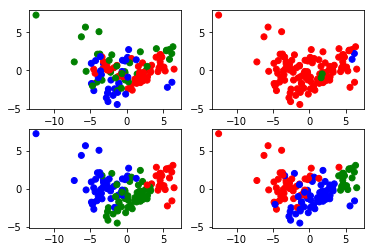

In [4]:
from sklearn.cluster import SpectralClustering;
sc1 = SpectralClustering(3, n_init=100, assign_labels='discretize', affinity='rbf');
labels1 = sc1.fit(X).labels_;
colors1 = ['r' if x==0 else 'b' if x==1 else 'g' for x in labels1];

sc2 = SpectralClustering(3, n_init=100, assign_labels='kmeans', affinity='rbf');
labels2 = sc2.fit(X).labels_;
colors2 = ['r' if x==0 else 'b' if x==1 else 'g' for x in labels2];

sc3 = SpectralClustering(3, n_init=100, assign_labels='discretize', affinity='nearest_neighbors');
labels3 = sc3.fit(X).labels_;
colors3 = ['r' if x==0 else 'b' if x==1 else 'g' for x in labels3];

sc4 = SpectralClustering(3, n_init=100, assign_labels='kmeans', affinity='nearest_neighbors');
labels4 = sc4.fit(X).labels_;
colors4 = ['r' if x==0 else 'b' if x==1 else 'g' for x in labels4];

fig = plt.figure();
ax1 = fig.add_subplot(221);
ax1.scatter([reduced[0,:]],[reduced[1,:]],c=colors1);
ax2 = fig.add_subplot(222);
ax2.scatter([reduced[0,:]],[reduced[1,:]],c=colors2);
ax3 = fig.add_subplot(223);
ax3.scatter([reduced[0,:]],[reduced[1,:]],c=colors3);
ax4 = fig.add_subplot(224);
ax4.scatter([reduced[0,:]],[reduced[1,:]],c=colors4);